## <div align="center"> TUGAS LAB IS794 DEEP LEARNING </div>
### <div align="center"> WEEK [12] : [Generative Deep Learning] </div>

#### <div align="center"> Semester Ganjil 2023/2024 </div>

#### Import library and load dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

127372/127372 [==============================] - 0s 3us/step


#### Setting DeepDream configuration & Defining the Loss

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 15.0

#### Display the original image

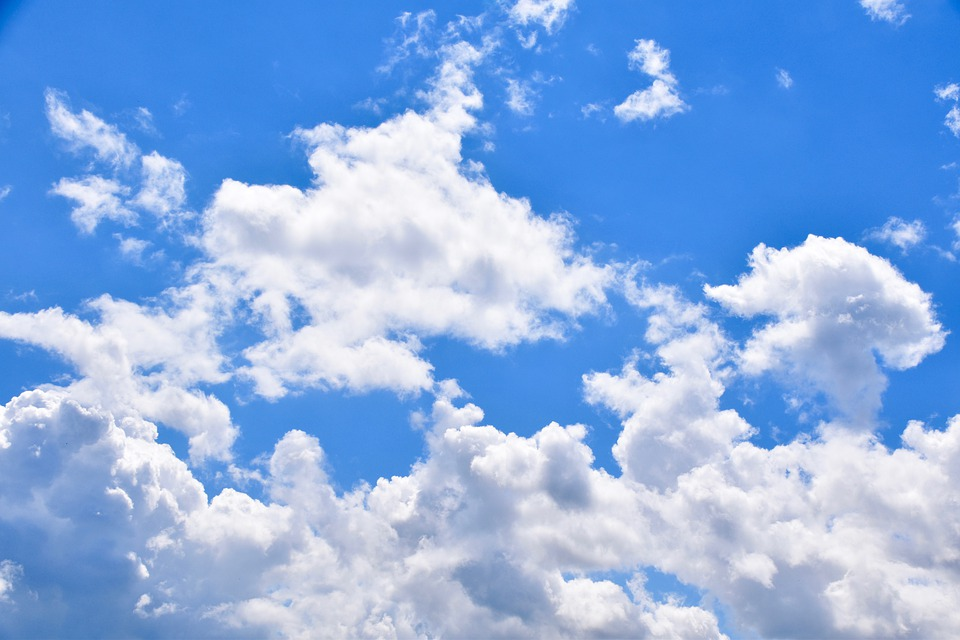

In [4]:
from IPython.display import Image, display

display(Image(base_image_path))

#### Define function to image processing

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

#### Build Inception V3 model using pre-trained ImageNet weights

In [6]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (gave them unique names)
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

87910968/87910968 [==============================] - 389s 4us/step


#### Define function to compute loss

In [7]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

#### Define function to gradient-ascent

In [8]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

#### Run the DeepDream

In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (326, 489)
... Loss value at step 0: 0.44
... Loss value at step 1: 0.62
... Loss value at step 2: 0.90
... Loss value at step 3: 1.25
... Loss value at step 4: 1.58
... Loss value at step 5: 1.92
... Loss value at step 6: 2.20
... Loss value at step 7: 2.52
... Loss value at step 8: 2.83
... Loss value at step 9: 3.11
... Loss value at step 10: 3.39
... Loss value at step 11: 3.66
... Loss value at step 12: 3.91
... Loss value at step 13: 4.18
... Loss value at step 14: 4.44
... Loss value at step 15: 4.68
... Loss value at step 16: 4.90
... Loss value at step 17: 5.15
... Loss value at step 18: 5.40
... Loss value at step 19: 5.61
Processing octave 1 with shape (457, 685)
... Loss value at step 0: 1.09
... Loss value at step 1: 1.76
... Loss value at step 2: 2.31
... Loss value at step 3: 2.79
... Loss value at step 4: 3.22
... Loss value at step 5: 3.65
... Loss value at step 6: 4.06
... Loss value at step 7: 4.43
... Loss value at step 8: 4.81
... Los

#### Save the result image

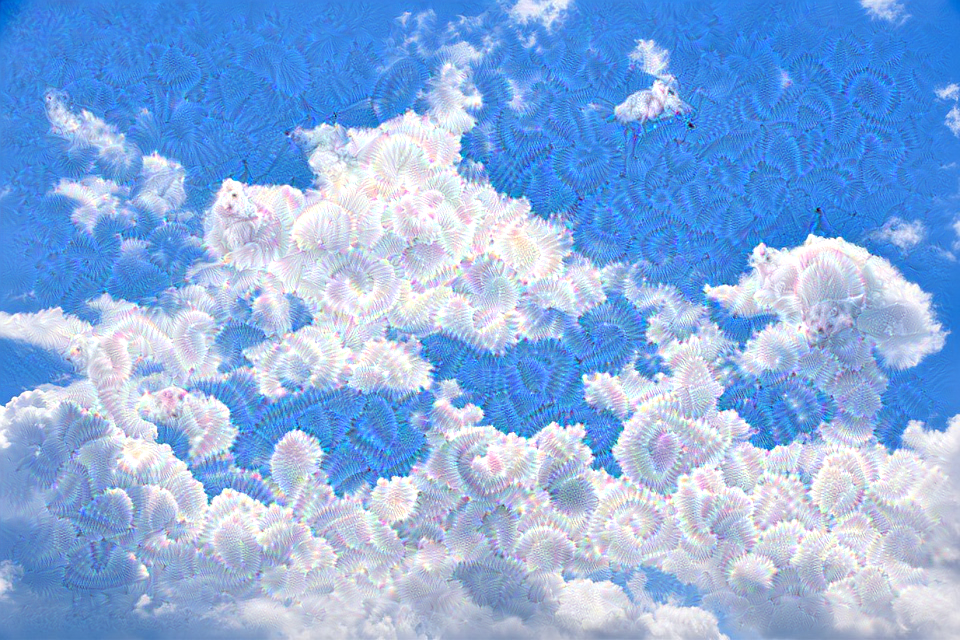

In [10]:
display(Image(result_prefix + ".png"))